# 05 — Exploration & plots\n\nLimpia ruido (ClusterID=-1), genera tablas y gráficos (hist/boxplot/XY/3D).

Puntos originales: 5,067,313 | sin ruido: 121,017
CSV clean → /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/processed/veg_gt2m_dbscan_clean.csv
Parquet clean → /Users/cecilialedesma/Library/Mobile Documents/com~apple~CloudDocs/projects_2025/lidar_vegetation_classification/notebooks/data/processed/veg_gt2m_dbscan_clean.parquet


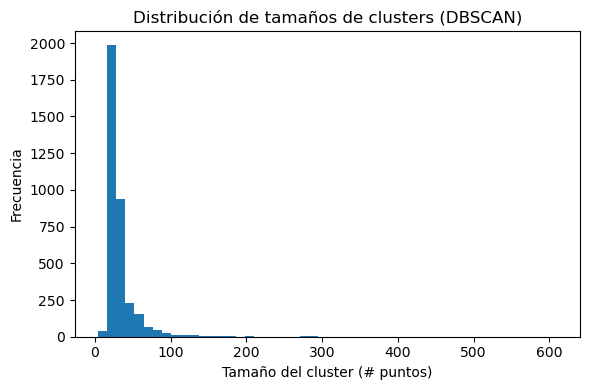

<Figure size 1000x500 with 0 Axes>

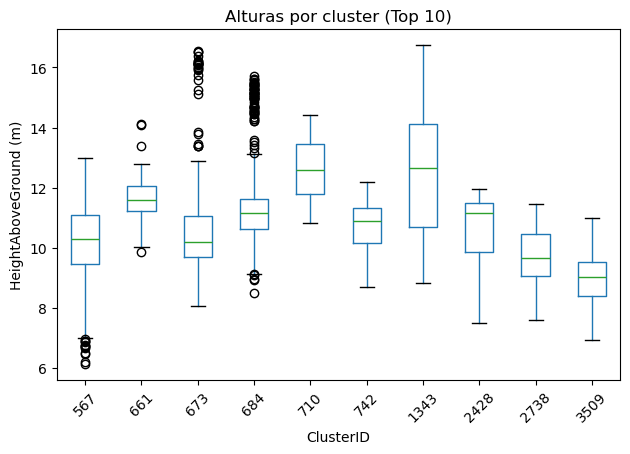

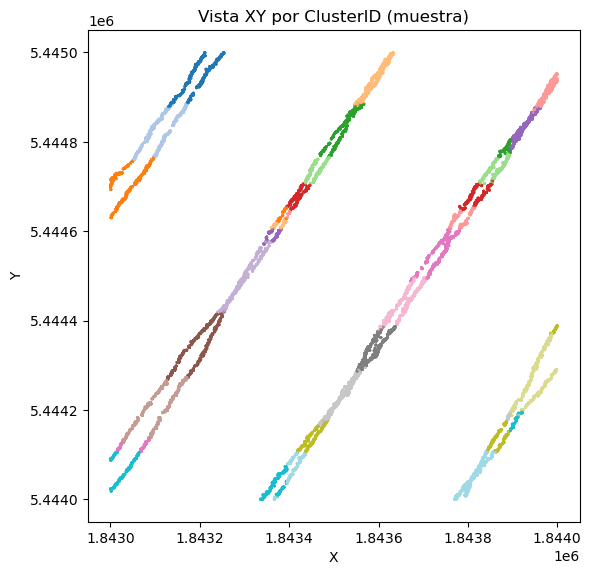

In [1]:

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px

ROOT = Path(".").resolve()
PROC = ROOT / "data" / "processed"

CSV_DBSCAN   = PROC / "veg_gt2m_dbscan.csv"
CSV_CLEAN    = PROC / "veg_gt2m_dbscan_clean.csv"
PARQ_CLEAN   = PROC / "veg_gt2m_dbscan_clean.parquet"

assert CSV_DBSCAN.exists(), f"Falta CSV DBSCAN: {CSV_DBSCAN}. Corré 04_dbscan.ipynb"

usecols = ["X","Y","Z","HeightAboveGround","ClusterID"]
dtypes  = {"X":"float32","Y":"float32","Z":"float32","HeightAboveGround":"float32","ClusterID":"int32"}
df = pd.read_csv(CSV_DBSCAN, usecols=usecols, dtype=dtypes)

df_clean = df[df["ClusterID"] != -1].copy()
df_clean.to_csv(CSV_CLEAN, index=False)
df_clean.to_parquet(PARQ_CLEAN, index=False)

print(f"Puntos originales: {len(df):,} | sin ruido: {len(df_clean):,}")
print("CSV clean →", CSV_CLEAN)
print("Parquet clean →", PARQ_CLEAN)

cluster_counts = (df_clean["ClusterID"].value_counts()
                  .rename_axis("ClusterID").reset_index(name="#puntos"))
stats = (df_clean.groupby("ClusterID")["HeightAboveGround"]
         .agg(n="count", mean="mean",
              p25=lambda s: s.quantile(0.25),
              median="median",
              p75=lambda s: s.quantile(0.75),
              max="max").reset_index().sort_values("n", ascending=False))

cluster_counts.to_csv(PROC / "cluster_sizes.csv", index=False)
stats.to_csv(PROC / "cluster_hag_stats.csv", index=False)

# Hist tamaños
plt.figure(figsize=(6,4))
plt.hist(cluster_counts["#puntos"], bins=50)
plt.xlabel("Tamaño del cluster (# puntos)")
plt.ylabel("Frecuencia")
plt.title("Distribución de tamaños de clusters (DBSCAN)")
plt.tight_layout(); plt.show()

# Boxplot top10
top_ids = cluster_counts["ClusterID"].head(10).tolist()
subset = df_clean[df_clean["ClusterID"].isin(top_ids)]
plt.figure(figsize=(10,5))
subset.boxplot(column="HeightAboveGround", by="ClusterID", grid=False, rot=45)
plt.ylabel("HeightAboveGround (m)")
plt.title("Alturas por cluster (Top 10)")
plt.suptitle(""); plt.tight_layout(); plt.show()

# XY muestra
sample = df_clean.sample(min(50_000, len(df_clean)), random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(sample["X"], sample["Y"], c=sample["ClusterID"], s=1, cmap="tab20", alpha=0.6)
plt.xlabel("X"); plt.ylabel("Y"); plt.title("Vista XY por ClusterID (muestra)")
plt.gca().set_aspect("equal", adjustable="box")
plt.tight_layout(); plt.show()

# 3D top-5
dfc = df_clean[["X","Y","HeightAboveGround","ClusterID"]].copy()
top5 = dfc["ClusterID"].value_counts().head(5).index.tolist()
sub = dfc[dfc["ClusterID"].isin(top5)].copy()
if len(sub) > 20_000: sub = sub.sample(20_000, random_state=42)
sub["Xn"] = sub["X"] - sub["X"].min()
sub["Yn"] = sub["Y"] - sub["Y"].min()
sub["ClusterID_str"] = sub["ClusterID"].astype(int).astype(str)

fig = px.scatter_3d(sub, x="Xn", y="Yn", z="HeightAboveGround",
                    color="ClusterID_str",
                    title="Clusters en 3D (submuestra normalizada)")
fig.update_traces(marker=dict(size=2, opacity=0.5))
fig.update_layout(scene_aspectmode="data"); fig.show()
